### Optimization for preceding train operation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import copy
from scipy.integrate import odeint
from datetime import datetime

import sys
sys.path.append("D:\Python\Jupyter_Code")
from utils import excelTools

from parameters import *
# from CASCO.paper2.DBO import *

In [2]:
""" 最速曲线导入 """
starting_time = ['nan'] * 13
ending_time = ['nan'] * 13

ds = 5

minitime_file = f'D:/Python/Jupyter_Code/CASCO/paper2//results/minitime_{ds}.xlsx'
minitime_df = pd.read_excel(minitime_file)
column_name2 = [f'whole ds={ds} s', f'whole ds={ds} v']
column_data2 = minitime_df[column_name2]
minitime_v = column_data2[f'whole ds={ds} v'].dropna().tolist()

if ds == 5:
    starting_time[6] = 4.107224
    starting_time[7] = 4.107224
    ending_time[6] = 2.604927
    ending_time[7] = 3.191198
elif ds == 10:
    starting_time[6] = 5.808492
    starting_time[7] = 4.86460
    ending_time[6] = 4.864602
    ending_time[7] = 5.198493

sub_dist = np.array(sub_dist)
station_idx = [np.where(sub_dist==each_station)[0].tolist()[0] for each_station in station_a_distance]
print(station_idx[6], station_idx[7], station_idx[8])
print(sub_dist[station_idx[6]], sub_dist[station_idx[7]], sub_dist[station_idx[8]])

2174 2432 2705
10785.0 12065.0 13419.0


In [3]:
""" 变量初始值定义 """
INIT_IDX = 0  # 初始索引
INIT_STATE = 4  # 初始状态 -- 到站
INIT_TIME = 0  # 初始时间
INIT_S = 0  # 初始位置
INIT_VELO = 1e-10  # 初始速度
INIT_A = 0  # 初始加速度
INIT_FT = 0  # 初始牵引力
INIT_FB = 0  # 初始制动力
INIT_ENER = 0  # 初始化能量消耗


def aCheck(a0, a1):
    delta_a = 0.6
    # 范围限制
    a1 = min(a1, MAX_ACC)
    # 变化率限制
    if a1 >= a0:
        a1 = min(a1, a0+delta_a)
    elif a1 < a0:
        a1 = max(a1, a0-delta_a)
        
    # 范围再次限制
    a1 = min(a1, MAX_ACC)

    return a1


# 列车状态判断
def stateAndF(a, f):
    
    if (a>0 and f>0) or (a<0 and f>0) :
        state = 0   # 牵引
        f_t, f_b = (f, 0)
    elif a==0 and f!=0:  
        state = 1   # 巡航
        if f > 0:
            f_t, f_b = (f, 0)
        elif f < 0:
            f_t, f_b = (0, f)
    elif f==0:  
        state = 2   # 滑行
        f_t, f_b = (0, 0)
    elif (a<0 and f<0):  
        state = 3   # 制动
        f_t, f_b = (0, f)

    return state, f_t, f_b

In [4]:
""" ode与rk4微分求解器 """
######################  利用python ode，效率较低  ######################
def dvdx_ode(v, x, a0, sub_idx, mode):
    if mode == 'Tr':
        a1 = (f_t(v)-f_b_r(v)-f_a_r(sub_gradient[sub_idx])) / MASS
    elif mode == 'Cr':
        a1 = 0
    elif mode == 'Co':
        a1 = (0-f_b_r(v)-f_a_r(sub_gradient[sub_idx])) / MASS
    elif mode == 'Br':
        a1 = (-f_b(v)-f_b_r(v)-f_a_r(sub_gradient[sub_idx])) / MASS
    # aCheck
    a1 = aCheck(a0, a1)

    return a1 / v

def trainOperate_ode(v0, a0, sub_idx, mode, h):
    if mode == 'Tr':
        a1 = (f_t(v0)-f_b_r(v0)-f_a_r(sub_gradient[sub_idx])) / MASS
    elif mode == 'Cr':
        a1 = 0
    elif mode == 'Co':
        a1 = (0-f_b_r(v0)-f_a_r(sub_gradient[sub_idx])) / MASS
    elif mode == 'Br':
        a1 = (-f_b(v0)-f_b_r(v0)-f_a_r(sub_gradient[sub_idx])) / MASS
    # aCheck
    a1 = aCheck(a0, a1)
    xlist = np.arange(sub_dist[sub_idx], sub_dist[sub_idx+1]+h, h)
    vlist = []
    varray = odeint(func=dvdx_ode, y0=v0, t=xlist, args=(a0, sub_idx, mode))
    vlist = [v[0] for v in varray]

    return a1, vlist, xlist

######################  利用4阶龙格库塔，注意：当v较小时（＜5）误差较大  ######################
def dvdx_rk4(sub_idx, v0, a0, mode):  # v'(x) = f(x, v) 微分方程
    if mode == 'Tr':
        a1 = (f_t(v0)-f_b_r(v0)-f_a_r(sub_gradient[sub_idx])) / MASS
    elif mode == 'Cr':
        a1 = 0
    elif mode == 'Co':
        a1 = (0-f_b_r(v0)-f_a_r(sub_gradient[sub_idx])) / MASS
    elif mode == 'Br':
        None
    
    a1 = aCheck(a0, a1)

    return a1 / v0, a1

def rk4(sub_idx, v0, a0, mode, n):
    h = sub_len[sub_idx] / n  # 步长， 自适应步长有些麻烦，感觉不如直接设置为5或者4

    k1, a1 = dvdx_rk4(sub_idx, v0, a0, mode)
    k2, _ = dvdx_rk4(sub_idx, (v0 + h/2*k1), a0, mode)
    k3, _ = dvdx_rk4(sub_idx, (v0 + h/2*k2), a0, mode)
    k4, _ = dvdx_rk4((sub_idx+1), (v0 + h*k3), a0, mode)  # 变量 _ : 不重要的变量

    v1 = v0 + h/6 * (k1 + 2*k2 + 2*k3 + k4)

    return a1, v1

def trainOperate_rk4(v0, a0, sub_idx, mode, n):
    """
    Parameters: 
        sub_idx --> x
        mode = {Tr, Cr, Co}
        n --> 步长缩放系数
    Atten: 输出的a1是列车在subsection进入点位置的加速度
    """
    xlist = np.linspace(sub_dist[sub_idx], sub_dist[sub_idx+1], n+1)
    vlist = [v0]
    # alist = [a0]
    a1, v1 = rk4(sub_idx, v0, a0, mode, n)
    vlist.append(v1)
    # alist.append(a1)
    for i in range(n-1):
        _, v1 = rk4(sub_idx, v1, a0, mode, n)  # q 这里应该是a0,因为a1-a0 < Δa是在整个sub上的限制
        vlist.append(v1)
        # alist.append(a1)
    
    return a1, vlist, xlist


In [5]:
# ode与rk4计算耗时对比
start_time = datetime.now()
for i in range(1):
    sub_idx = station_idx[6]
    v0 = 3
    a0 = 0
    a1, v1, x1 = trainOperate_rk4(v0, a0, sub_idx,'Tr', n=2)
    a2, v2, x2 = trainOperate_ode(v0, a0, sub_idx, 'Tr', h=1)
    print(f"4阶Runge-kutta, v1={v1[-1]}")
    print(f"python ode, v1={v2[-1]}")
    print(f"error = {v1[-1] - v2[-1]}")
end_time = datetime.now()
print("消耗时间：", (end_time - start_time).total_seconds(), "秒")

4阶Runge-kutta, v1=3.8729890381907555
python ode, v1=3.8729832197029026
error = 5.818487852859988e-06
消耗时间： 0.0 秒


### 1. 列车最大牵引 Train traction mode

In [ ]:
a1, v1, x1 = trainOperate_ode(2.898275395, 0, station_idx[7]-1, 'Br', h=1)
_1_v1 = [1/v for v in v1]
print(v1, x1)
# t_inte_n = np.trapz(_1_v1[1:], x1[1:])+(2*1/(v1[0]+v1[1]))
t_inte_n = np.trapz(_1_v1[0:-1], x1[0:-1])+(2*1/(v1[-1]+v1[-2]))
t_aver = 2*10 / (v1[0]+v1[-1])
t_inte_n, t_aver

In [ ]:
""" 重构vlist,重构的vlist不准确，也浪费时间 """
# """ 列车最大牵引 """
# # Tr --> 0, Cr --> 1, Co --> 2, Br --> 3

# station = [6, 7, 8]

# train1 = Train()
# train1.clear()
# train1.listExpand(float('nan'))

# idx = INIT_IDX
# train1.idx[0] = INIT_IDX
# train1.state[0] = INIT_STATE
# train1.t[0] = INIT_TIME
# train1.s[0] = station_a_distance[station[0]]
# train1.v[0] = INIT_VELO
# train1.a[0] = INIT_A
# train1.f_t[0] = INIT_FT
# train1.f_b[0] = INIT_FB
# train1.e[0] = INIT_ENER


# def trainTrack(line, train, idx, s_start, s_end, h, n):
#     """
#     parameters: 
#     train -- class Train();
#     s_start -- idx of starting subsection 
#     s_end -- idx of end subsection
#     h -- the step of ode 
#     n -- the step scale factor of rk4 
#     """
#     for j in range(s_start, s_end):
#         idx += 1
#         train.listExpand(float('nan'))
#         train.idx[idx] = idx
#         sub_idx = j

#         # 计算微分速度  
#         if train.v[idx-1] < 2:
#             train.a[idx], vlist, xlist = trainOperate_ode(train.v[idx-1], train.a[idx-1], sub_idx, 'Tr', h)  # 注意：a并不是微分a,而是v0点计算的a
#         elif train.v[idx-1] >= 2:
#             train.a[idx], vlist, xlist = trainOperate_rk4(train.v[idx-1], train.a[idx-1], sub_idx, 'Tr', n)
#         train.v[idx] = vlist[-1]

#         # 超速判断
#         if train.v[idx] > minitime_v[sub_idx+1]:
#             train.v[idx] = minitime_v[sub_idx+1]
#             expect_a = (train.v[idx]**2-train.v[idx-1]**2) / (2*sub_len[sub_idx])  # 按匀变速直线运动处理

#             # atten 
#             # 若expect_a>0, 则根据max_a >= checked max_a >= expect_a，--> expect_a一定可取
#             # 若expect_a<0, 则需对比电机可取的最小加速度. 但似乎expect_a和最后计算的train.a没有误差.
#             # 并且严格来说,应该是通过Br模式下的微分来计算新的速度
#             if expect_a < 0: 
#                 min_a0 = (-f_b(train.v[idx-1]) -f_b_r(train.v[idx-1]) -f_a_r(sub_gradient[sub_idx])) / MASS
#                 min_a1 = (-f_b(train.v[idx]) -f_b_r(train.v[idx]) -f_a_r(sub_gradient[sub_idx])) / MASS  # 高速时的制动加速度
#                 min_a = max(min_a0, min_a1)
#                 expect_a = max(expect_a, min_a)
            
#             # 重新检查a的边界和变化率
#             train.a[idx] = aCheck(train.a[idx-1], expect_a)  # 目前：all (train1.a[idx] == expect_a) is true
#             # 如果train1.a[idx] != expect_a，需要重新计算速度
#             if train.a[idx] != expect_a: 
#                 train.v[idx] = (2*train.a[idx]*sub_len[sub_idx] + train.v[idx-1]**2) ** 0.5  # q 是否需要判断 2ax+v0^2 <=0 ?
            
#             # 重构vlist  # atten 在牵引过程中，真实的vlist的Δv是一个递减数列，而不是等差数列，所以难以构建真实的vlist
#             vlist = np.linspace(train.v[idx-1], train.v[idx], len(xlist))
        
#         _1_vlist = [1/v for v in vlist]

#         # 更新位移
#         train.s[idx] = train.s[idx-1] + sub_len[sub_idx]

#         # 积分更新时间 # atten 在出发时刻和到达时刻由于速度小于0.1，会造成比较大的误差，因此离线计算
#         if train.v[idx-1] < 1 and train.v[idx] > 1:
#             delta_t = starting_time[line]
#         elif train.v[idx-1] > 1 and train.v[idx] < 1:
#             delta_t = ending_time[line]
#         else:
#             delta_t = (np.trapz(_1_vlist, x=xlist)).item()  # (x0, ...,x1) trapz integration
#             # delta_t = (sub_len[sub_idx]/2) * (1/train.v[idx-1]+1/train.v[idx])  # (x0, x1)trapz integration
#             # delta_t = (2*sub_len[sub_idx]) / (train.v[idx-1]+train.v[idx])  # average
#         train.t[idx] = train.t[idx-1] + delta_t
        

#         # 更新力
#         f = (MASS*train.a[idx] + f_b_r(train.v[idx-1]) + f_a_r(sub_gradient[sub_idx]))  # 力是在subsection进入点位置的力
#         train.state[idx], train.f_t[idx], train.f_b[idx] = stateAndF(train.a[idx], f)

#         # 积分更新阻力做功，动能定理计算能耗
        
#         # e_fr = np.trapz(fbrlist, xlist)  # 积分改为中值定理, 误差很小
#         e_fr = (f_b_r(train.v[idx-1]) + f_b_r(train.v[idx]))/2 * sub_len[sub_idx]
#         delta_e = abs(0.5*MASS*train.v[idx]**2 - 0.5*MASS*train.v[idx-1]**2 + abs(e_fr) + f_a_r(sub_gradient[sub_idx])*sub_len[sub_idx])
#         delta_e = delta_e / (3.6 * 10**6)
#         train.e[idx] =  train.e[idx-1] + delta_e

#     return train, idx

   
# start_time = datetime.now()

# for j in range(1):
#     for i in range(len(station)-1):
#         train1, idx = trainTrack(station[i], train1, idx, station_idx[station[i]], station_idx[station[i]+1], 1, 2)
#         train1.a[idx] = 0 
#         train1.v[idx] = 1e-10

# end_time = datetime.now()

# print("消耗时间：", (end_time - start_time).total_seconds(), "秒")
# train1.t[-1], train1.e[-1]
    

In [8]:
""" 列车最大牵引 """
# Tr --> 0, Cr --> 1, Co --> 2, Br --> 3

station = [6, 7, 8]

train1 = Train()
train1.clear()
train1.listExpand(float('nan'))

idx = INIT_IDX
train1.idx[0] = INIT_IDX
train1.state[0] = INIT_STATE
train1.t[0] = INIT_TIME
train1.s[0] = station_a_distance[station[0]]
train1.v[0] = INIT_VELO
train1.a[0] = INIT_A
train1.f_t[0] = INIT_FT
train1.f_b[0] = INIT_FB
train1.e[0] = INIT_ENER


def trainTrack(station, train, idx, s_start, s_end, h, n):
    """
    parameters: 
    train -- class Train();
    s_start -- idx of starting subsection 
    s_end -- idx of end subsection
    h -- the step of ode 
    n -- the step scale factor of rk4 
    """
    for j in range(s_start, s_end):
        idx += 1
        train.listExpand(float('nan'))
        train.idx[idx] = idx
        sub_idx = j

        # 计算微分速度  
        if train.v[idx-1] < 2:
            train.a[idx], vlist, xlist = trainOperate_ode(train.v[idx-1], train.a[idx-1], sub_idx, 'Tr', h)  # 注意：a并不是微分a,而是v0点计算的a
        elif train.v[idx-1] >= 2:
            train.a[idx], vlist, xlist = trainOperate_rk4(train.v[idx-1], train.a[idx-1], sub_idx, 'Tr', n)
        train.v[idx] = vlist[-1]

        # 未超速
        if train.v[idx] <= minitime_v[sub_idx+1]:
            # 多点积分更新时间 # atten 在出发时刻和到达时刻由于速度小于0.1，会造成比较大的误差，因此离线计算
            # _1_vlist = [1/v for v in vlist]
            if train.v[idx-1] < 1 and train.v[idx] > 1:
                delta_t = starting_time[station]
            elif train.v[idx-1] > 1 and train.v[idx] < 1:
                delta_t = ending_time[station]
            else:
                # delta_t = (np.trapz(_1_vlist, x=xlist)).item()  # (x0, ...,x1) trapz integration
                # delta_t = (sub_len[sub_idx]/2) * (1/train.v[idx-1]+1/train.v[idx])  # (x0, x1)trapz integration
                delta_t = (2*sub_len[sub_idx]) / (train.v[idx-1]+train.v[idx])  # average # atten 虽然按照匀变速计算不对，但是误差在可接受范围内
        
        # 超速
        elif train.v[idx] > minitime_v[sub_idx+1]:
            train.v[idx] = minitime_v[sub_idx+1]
            expect_a = (train.v[idx]**2-train.v[idx-1]**2) / (2*sub_len[sub_idx])  # 按匀变速直线运动处理

            # atten 
            # 若expect_a>0, 则根据max_a >= checked max_a >= expect_a，--> expect_a一定可取
            # 若expect_a<0, 则需对比电机可取的最小加速度. 但似乎expect_a和最后计算的train.a没有误差.
            # 并且严格来说,应该是通过Br模式下的微分来计算新的速度
            if expect_a < 0: 
                min_a0 = (-f_b(train.v[idx-1]) -f_b_r(train.v[idx-1]) -f_a_r(sub_gradient[sub_idx])) / MASS
                min_a1 = (-f_b(train.v[idx]) -f_b_r(train.v[idx]) -f_a_r(sub_gradient[sub_idx])) / MASS  # 高速时的制动加速度
                min_a = max(min_a0, min_a1)
                expect_a = max(expect_a, min_a)
            
            # 重新检查a的边界和变化率
            train.a[idx] = aCheck(train.a[idx-1], expect_a)  # 目前：all (train1.a[idx] == expect_a) is true
            # 如果train1.a[idx] != expect_a，需要重新计算速度
            if train.a[idx] != expect_a: 
                train.v[idx] = (2*train.a[idx]*sub_len[sub_idx] + train.v[idx-1]**2) ** 0.5  # q 是否需要判断 2ax+v0^2 <=0 ?
            
            # 计算Δt
            if train.v[idx-1] > 1 and train.v[idx] < 1:
                delta_t = ending_time[station]
            else:
                # delta_t = (sub_len[sub_idx]/2) * (1/train.v[idx-1]+1/train.v[idx])
                delta_t = (2*sub_len[sub_idx]) / (train.v[idx-1]+train.v[idx])  # atten 虽然按照匀变速计算是不对的，但是误差却比两点积分要小
            # atten 在牵引过程中，真实vlist的Δv是一个递减数列，而不是等差数列，所以难以重构真实的vlist
            # vlist = np.linspace(train.v[idx-1], train.v[idx], len(xlist))  # 重构vlist
 
        # 更新位移和时间
        train.s[idx] = train.s[idx-1] + sub_len[sub_idx]
        train.t[idx] = train.t[idx-1] + delta_t

        # 更新力
        f = (MASS*train.a[idx] + f_b_r(train.v[idx-1]) + f_a_r(sub_gradient[sub_idx]))  # 力是在subsection进入点位置的力
        train.state[idx], train.f_t[idx], train.f_b[idx] = stateAndF(train.a[idx], f)

        # 积分更新阻力做功，动能定理计算能耗
        # e_fr = np.trapz(fbrlist, xlist)  # 积分改为中值定理, 误差很小
        e_fr = (f_b_r(train.v[idx-1]) + f_b_r(train.v[idx]))/2 * sub_len[sub_idx]
        if train.f_t[idx] > 0:
            delta_e = 0.5*MASS*train.v[idx]**2 - 0.5*MASS*train.v[idx-1]**2 + abs(e_fr) + f_a_r(sub_gradient[sub_idx])*sub_len[sub_idx]
        else:
            delta_e = 0
        train.e[idx] =  train.e[idx-1] + delta_e/(3.6 * 10**6)

    return train, idx

   
start_time = datetime.now()
for j in range(1):
    for i in range(len(station)-1):
        train1, idx = trainTrack(station[i], train1, idx, station_idx[station[i]], station_idx[station[i]+1], 1, 2)
        train1.a[idx] = 0 
        train1.v[idx] = 1e-10


end_time = datetime.now()

print("消耗时间：", (end_time - start_time).total_seconds(), "秒")
train1.t[-1], train1.e[-1]
    

消耗时间： 0.036411 秒


(173.28621583387945, 42.55183626403813)

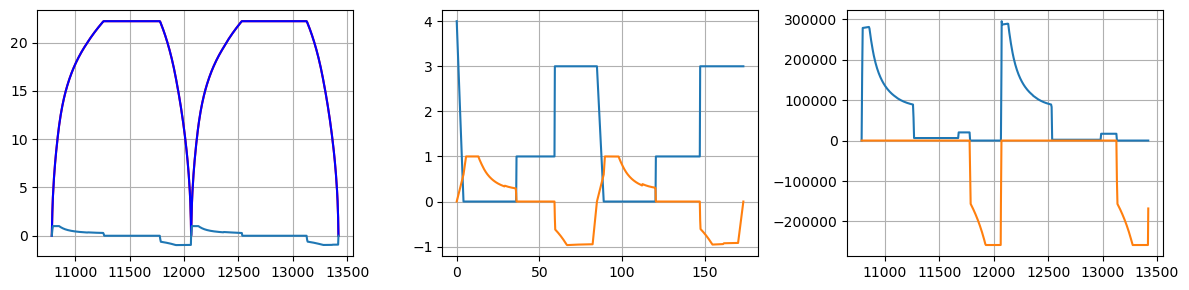

In [9]:
fig = plt.figure(figsize=(12, 3))
plt.subplot(1,3,1)
plt.plot(sub_dist[station_idx[station[0]]:station_idx[station[2]]+1], minitime_v[station_idx[station[0]]:station_idx[station[2]]+1], 'r')
plt.plot(train1.s, train1.v, 'b')
plt.plot(train1.s, train1.a)
plt.grid()
plt.subplot(1,3,2)
plt.plot(train1.t, train1.state)
plt.plot(train1.t, train1.a)
plt.grid()
plt.subplot(1,3,3)
plt.plot(train1.s, train1.f_t)
plt.plot(train1.s, train1.f_b)
plt.grid()
plt.tight_layout()

### 2. 列车匀速巡航 Train cruise mode

In [22]:
""" 列车巡航 """
train2 = Train()
train2.clear()
train2.listExpand(float('nan'))

idx = INIT_IDX
train2.idx[0] = INIT_IDX
train2.t[0] = INIT_TIME
train2.s[0] = 11162
where_idx = np.where(sub_dist==train2.s[0])[0].tolist()[0]
train2.v[0] = 18
train2.a[0] = INIT_A
train2.f_t[0] = INIT_FT
train2.f_b[0] = INIT_FB
train2.e[0] = INIT_ENER

def trainCruise(station, train, idx, s_start, s_end, h, n):
    for j in range(s_start, s_end):
        idx += 1
        train.listExpand(float('nan'))
        train.idx[idx] = idx
        sub_idx = j
        
        # 更新速度: 匀速
        if train.v[idx-1] < 2:
            train.a[idx], vlist, xlist = trainOperate_ode(train.v[idx-1], train.a[idx-1], sub_idx, 'Cr', h)  # 注意：a并不是微分a,而是v0点计算的a
        elif train.v[idx-1] >= 2:
            train.a[idx], vlist, xlist = trainOperate_rk4(train.v[idx-1], train.a[idx-1], sub_idx, 'Cr', n)
        train.v[idx] = vlist[-1]

        if train.v[idx] > minitime_v[sub_idx+1]:
            train.v[idx] = minitime_v[sub_idx+1]
            expect_a = (train.v[idx]**2-train.v[idx-1]**2) / (2*sub_len[sub_idx])

            if expect_a < 0: # 说明最速v_k1小于v_k0，需要制动减速；可能需要判断a的变化率
                min_a0 = (-f_b(train.v[idx-1]) -f_b_r(train.v[idx-1]) -f_a_r(sub_gradient[sub_idx])) / MASS
                min_a1 = (-f_b(train.v[idx]) -f_b_r(train.v[idx]) -f_a_r(sub_gradient[sub_idx])) / MASS  # 高速时的制动加速度
                min_a = max(min_a0, min_a1)
                expect_a = max(expect_a, min_a)

            train.a[idx] = aCheck(train.a[idx-1], expect_a)  # all (train2.a[idx] == expect_a) is true
            if train.a[idx] != expect_a:  # 如果train2.a[idx] != expect_a，需要重新计算速度
                train.v[idx] = (2*train.a[idx]*sub_len[sub_idx] + train.v[idx-1]**2) ** 0.5  # q 是否需要判断 2ax+v0^2 <=0 ?
        
        # 更新位移和时间
        train.s[idx] = train.s[idx-1] + sub_len[sub_idx]

        # 更新时间: 'Cr'模式中仅考虑匀速巡航过程,故运行时间可以通过均值简化处理
        if train.v[idx-1] > 1 and train.v[idx] < 1:
            delta_t = ending_time[station]
        else:
            # delta_t = (sub_len[sub_idx]/2) * (1/train.v[idx-1]+1/train.v[idx])
            delta_t = (2*sub_len[sub_idx]) / (train.v[idx-1]+train.v[idx])
        train.t[idx] = train.t[idx-1] + delta_t

        # 更新力
        f = (MASS*train.a[idx] + f_b_r(train.v[idx-1]) + f_a_r(sub_gradient[sub_idx]))
        train.state[idx], train.f_t[idx], train.f_b[idx] = stateAndF(train.a[idx], f)

        # 更新能耗: 仅考虑匀速过程, 摩擦力做功简化处理
        e_fr = (f_b_r(train.v[idx-1]) + f_b_r(train.v[idx]))/2 * sub_len[sub_idx]
        if f>0:
            delta_e = abs(0.5*MASS*train.v[idx]**2 - 0.5*MASS*train.v[idx-1]**2 + abs(e_fr) + f_a_r(sub_gradient[sub_idx])*sub_len[sub_idx])
        else:
            delta_e = 0
        delta_e = delta_e / (3.6 * 10**6)
        train.e[idx] =  train.e[idx-1] + delta_e 

    return train, idx


start_time = datetime.now()
for j in range(1):
    for i in range(1):
        train2, idx = trainCruise(station[i], train2, idx, where_idx, station_idx[station[i+1]], 1, 2)
        train2.a[idx] = 0 
        train2.v[idx] = 1e-10
end_time = datetime.now()

print("消耗时间：", (end_time - start_time).total_seconds(), "秒")
train2.t[-1]


消耗时间： 0.004 秒


60.5542035985321

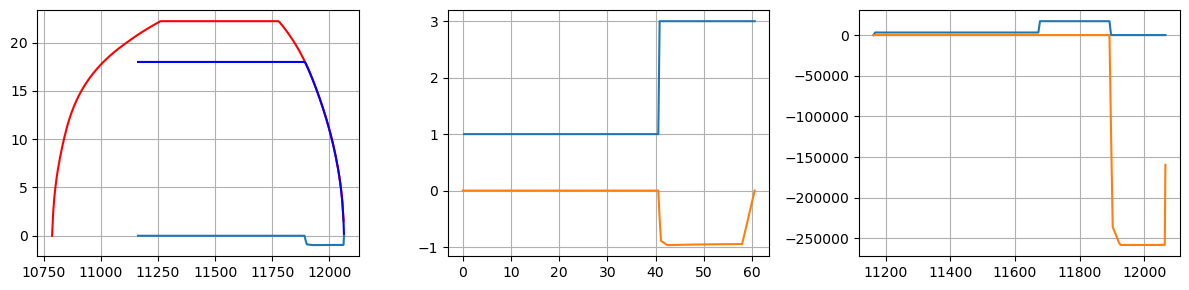

In [97]:
fig = plt.figure(figsize=(12, 3))
plt.subplot(1,3,1)
plt.plot(sub_dist[station_idx[station[i]]:station_idx[station[i+1]]], minitime_v[station_idx[station[i]]:station_idx[station[i+1]]], 'r')
plt.plot(train2.s, train2.v, 'b')
plt.plot(train2.s, train2.a)
plt.grid()
plt.subplot(1,3,2)
plt.plot(train2.t, train2.state)
plt.plot(train2.t, train2.a)
plt.grid()
plt.subplot(1,3,3)
plt.plot(train2.s, train2.f_t)
plt.plot(train2.s, train2.f_b)
plt.grid()
plt.tight_layout()

### 3. 列车滑行 Train coast mode

In [134]:
a1, v1, x1 = trainOperate_ode(18, 0, where_idx, 'Co', 1)
a2, v2, x2 = trainOperate_rk4(18, 0, where_idx, 'Co', 4)
print(a1, a2)
print(v1[-1]-v2[-1])

-0.011153574325394731 -0.011153574325394731
5.7273567222182464e-08


In [23]:
""" 列车滑行 """
# Tr --> 0, Cr --> 1, Co --> 2
train3 = Train()
train3.clear()
train3.listExpand(float('nan'))

idx = INIT_IDX
train3.idx[0] = INIT_IDX
train3.t[0] = INIT_TIME
train3.s[0] = 11262
where_idx = np.where(sub_dist==train3.s[0])[0].tolist()[0]
train3.v[0] = 80/3.6
train3.a[0] = 1
train3.f_t[0] = INIT_FT
train3.f_b[0] = INIT_FB
train3.e[0] = INIT_ENER


def trainCoast(station, train, idx, s_start, s_end, dx, h):
    for j in range(s_start, s_end):
        idx += 1
        train.listExpand(float('nan'))
        train.idx[idx] = idx
        sub_idx = j

        # 计算微分速度  
        if train.v[idx-1] < 3:
            train.a[idx], vlist, xlist = trainOperate_ode(train.v[idx-1], train.a[idx-1], sub_idx, 'Co', dx)  # 注意：a并不是微分a,而是v0点计算的a
        elif train.v[idx-1] >= 3:
            train.a[idx], vlist, xlist = trainOperate_rk4(train.v[idx-1], train.a[idx-1], sub_idx, 'Co', h)

        train.v[idx] = vlist[-1]

        if train.v[idx] <= minitime_v[sub_idx+1]:

            # _1_vlist = [1/v for v in vlist]
            if train.v[idx-1] < 1 and train.v[idx] > 1:
                delta_t = starting_time[station]
            elif train.v[idx-1] > 1 and train.v[idx] < 1:
                delta_t = ending_time[station]
            else:
                # delta_t = (np.trapz(_1_vlist, x=xlist)).item()
                delta_t = (2*sub_len[sub_idx]) / (train.v[idx-1]+train.v[idx])
        
        elif train.v[idx] > minitime_v[sub_idx+1]:
            train.v[idx] = minitime_v[sub_idx+1]
            expect_a = (train.v[idx]**2-train.v[idx-1]**2) / (2*sub_len[sub_idx])

            if expect_a < 0: # 说明最速v_k1小于v_k0，需要制动减速；可能需要判断a的变化率
                min_a0 = (-f_b(train.v[idx-1]) -f_b_r(train.v[idx-1]) -f_a_r(sub_gradient[sub_idx])) / MASS
                min_a1 = (-f_b(train.v[idx]) -f_b_r(train.v[idx]) -f_a_r(sub_gradient[sub_idx])) / MASS  # 高速时的制动加速度
                min_a = max(min_a0, min_a1)
                expect_a = max(expect_a, min_a)

            train.a[idx] = aCheck(train.a[idx-1], expect_a)  # all (train3.a[idx] == expect_a) is true
            if train.a[idx] != expect_a:  # 如果train3.a[idx] != expect_a，需要重新计算速度
                train.v[idx] = (2*train.a[idx]*sub_len[sub_idx] + train.v[idx-1]**2) ** 0.5  # q 是否需要判断 2ax+v0^2 <=0 ?
            
            # 计算delta_t
            if train.v[idx-1] > 1 and train.v[idx] < 1:
                delta_t = ending_time[station]
            else:
                # delta_t = (sub_len[sub_idx]/2) * (1/train.v[idx-1]+1/train.v[idx])
                delta_t = (2*sub_len[sub_idx]) / (train.v[idx-1]+train.v[idx])

        # 更新力和状态
        f = (MASS*train.a[idx] + f_b_r(train.v[idx-1]) + f_a_r(sub_gradient[sub_idx]))  # f是列车在subsection进入点位置的力
        if -10 < f < 10:
            f = 0
        train.state[idx], train.f_t[idx], train.f_b[idx] = stateAndF(train.a[idx], f)

        # 更新位移和时间
        train.s[idx] = train.s[idx-1] + sub_len[sub_idx]
        train.t[idx] = train.t[idx-1] + delta_t
    
        # 更新能耗
        e_fr = (f_b_r(train.v[idx-1]) + f_b_r(train.v[idx]))/2 * sub_len[sub_idx]
        if f>10:
            delta_e = 0.5*MASS*train.v[idx]**2 - 0.5*MASS*train.v[idx-1]**2 + abs(e_fr) + f_a_r(sub_gradient[sub_idx])*sub_len[sub_idx]
        else:
            delta_e = 0
        delta_e = delta_e / (3.6 * 10**6)
        train.e[idx] =  train.e[idx-1] + delta_e

    return train, idx


start_time = datetime.now()
for i in range(1):
    train3, idx = trainCoast(station[i], train3, idx, where_idx, station_idx[station[i]+1], 1, 2)
    train3.a[idx] = 0 
    train3.v[idx] = 1e-10
end_time = datetime.now()
print("消耗时间：", (end_time - start_time).total_seconds(), "秒")
train3.t[-1], train3.e[-1]

消耗时间： 0.006001 秒


(49.1339493216649, 0.16650645530667613)

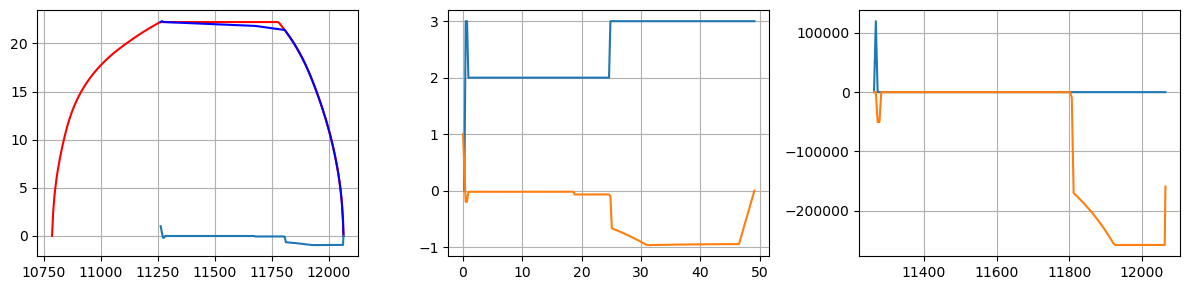

In [58]:
fig = plt.figure(figsize=(12, 3))
plt.subplot(1,3,1)
plt.plot(sub_dist[station_idx[station[0]]:station_idx[station[1]]+1], minitime_v[station_idx[station[0]]:station_idx[station[1]]+1], 'r')
plt.plot(train3.s, train3.v, 'b')
plt.plot(train3.s, train3.a)
plt.grid()
plt.subplot(1,3,2)
plt.plot(train3.t, train3.state)
plt.plot(train3.t, train3.a)
plt.grid()
plt.subplot(1,3,3)
plt.plot(train3.s, train3.f_t)
plt.plot(train3.s, train3.f_b)
plt.tight_layout()
plt.grid()

### 4. 到站 train arrival

In [24]:
""" 列车到站 """
def trainArrival(station, train, idx):
    train.arrival_time.append(train.t[idx]) 
    # 到站     
    train.listExpand(float('nan'))
    idx += 1
    train.idx[idx] = idx
    train.state[idx], train.a[idx], train.v[idx], train.f_t[idx], train.f_b[idx] = INIT_STATE, INIT_A, INIT_VELO, INIT_FT, INIT_FB
    train.t[idx] = train.t[idx-1]
    train.s[idx] = train.s[idx-1]
    train.e[idx] = train.e[idx-1]
    # 再出发
    train.listExpand(float('nan'))
    idx += 1
    train.idx[idx] = idx
    train.state[idx], train.a[idx], train.v[idx], train.f_t[idx], train.f_b[idx] = INIT_STATE, INIT_A, INIT_VELO, INIT_FT, INIT_FB
    train.t[idx] = train.t[idx-1] + dw_time[station]
    train.s[idx] = train.s[idx-1]
    train.e[idx] = train.e[idx-1]

    return train, idx

In [ ]:
train4 = Train()
train4.clear()
train4.listExpand(float('nan'))

idx = INIT_IDX
train4.idx[0] = INIT_IDX
train4.t[0] = INIT_TIME
train4.s[0] = station_a_distance[L1]
train4.v[0] = INIT_VELO
train4.a[0] = INIT_A
train4.f_t[0] = INIT_FT
train4.f_b[0] = INIT_FB
train4.e[0] = INIT_ENER

train4, idx = trainTrack(train4, idx, station_idx[L1], 2240, 1, 4)
trian4, idx = trainCruise(train4, idx, 2240, 2290)
train4, idx = trainCoast(trian4, idx, 2290, station_idx[L1+1], 1, 4)
train4, idx = trainArrival(train4, idx, 6)
fig = plt.figure(figsize=(12, 3))

plt.subplot(1,3,1)
plt.plot(sub_dist[station_idx[L1]:station_idx[L1+1]+1], minitime_v[station_idx[L1]:station_idx[L1+1]+1], 'r')
plt.plot(train4.s, train4.v, 'b')
plt.plot(train4.s, train4.a)
plt.grid()
plt.subplot(1,3,2)
plt.plot(train4.t, train4.state)
plt.plot(train4.t, train4.a)
plt.grid()
plt.subplot(1,3,3)
plt.plot(train4.s, train4.f_t)
plt.plot(train4.s, train4.f_b)
plt.tight_layout()
plt.grid()

### 5. 基础mode仿真测试

In [25]:
def trainTrip(x, dim, station, train, h, n):

    train.clear()
    train.listExpand(float('nan'))

    idx = INIT_IDX
    train.state[0] = INIT_STATE
    train.idx[0] = INIT_IDX
    train.t[0] = INIT_TIME
    train.s[0] = station_a_distance[station[0]]
    train.v[0] = INIT_VELO
    train.a[0] = INIT_A
    train.f_t[0] = INIT_FT
    train.f_b[0] = INIT_FB
    train.e[0] = INIT_ENER

    for i in range(len(station)-1):
        k = 2
        train, idx = trainTrack(station[i], train, idx, station_idx[station[i]], x[k*i], h, n)
        train, idx = trainCruise(station[i], train, idx, x[k*i], x[k*i+1], h, n)
        train, idx = trainCoast(station[i], train, idx, x[k*i+1], station_idx[station[i+1]], h, n)
        train, idx = trainArrival(station[i], train, idx)

    return train


'''目标函数'''
def Fun(x, dim, station, train):
    # print(x)
    fitness = 0
    h = 1
    n = 2
    train = trainTrip(x, dim, station, train, h, n)
    w_e = 0.1 # 能耗权重
    w_t = 10 # 准时性权重
    fitness = w_e*train.e[-1] + w_t*(abs(train.arrival_time[0]-op_time[6])**3 + abs(train.arrival_time[1]-op_time[6]-op_time[7]-30)**3)

    return fitness


In [26]:
""" 初始化种群 """
def Initialize(pop, dim, lb, ub):
    # np.random.seed(3)
    X= np.random.randint(low=lb, high=ub, size=(pop, dim))
    for i in range(pop):
        X[i] = np.sort(X[i])

    fitness = np.zeros(pop)    
    return X, lb, ub, fitness


""" 计算适应度函数 """
# def Fun()...


""" 边界检查 """
def BoundaryCheck(input, dim, lb, ub):
    temp = input
    # 范围
    for i in range(len(input)):
        if temp[i] < lb[i]:
            temp[i] = lb[i]
        elif temp[i] > ub[i]:
            temp[i] = ub[i]
    
    # x0, x1, x2...的大小关系:
    if dim == 4:
        for i in [0,2]:
            if (temp[i+1]>=temp[i]) is not True:
                # temp[i+1] = np.random.randint(temp[i], ub[i+1]-10)
                temp[i+1] = temp[i] + np.random.randint(0, 30)
                # temp[i+1] = temp[i]
    elif dim == 6:
        for i in [0,3]:
            if (temp[i+2]>=temp[i+1]>=temp[i]) is not True:
                # temp[i+1] = np.random.randint(temp[i], ub[i+1])
                temp[i+1] = temp[i] + np.random.randint(0,5)
                temp[i+2] = temp[i+1] + np.random.randint(0,15)
    elif dim == 8:
        for i in [0,4]:
            if (temp[i+3]>temp[i+2]>temp[i+1]>temp[i]) is not True:
                temp[i+1] = temp[i]
                temp[i+2] = temp[i+1]
                temp[i+3] = temp[i+2]

    return temp

""" 优化算法 """
def DBO(p_percent, pop, dim, max_iter, lb, ub, fun, L, train1, train2):
    """
    :param fun: 适应度函数
    :param pop: 种群数量
    :param m: 迭代次数
    :param c: 迭代范围下界
    :param d: 迭代范围上界
    :param dim: 优化参数的个数
    :return: 适应度值最小的值 对应得位置
    """
    pNum = round(pop*p_percent)
    record_gfitness = []
    X, lb, ub, pfitness = Initialize(pop, dim, lb, ub)
    X_now = copy.copy(X)
    X_last = copy.copy(X_now)
    
    for i in range(pop):
        pfitness[i] = fun(X_now[i], dim, L, train1)
    pfitness_now = copy.copy(pfitness)
    gfitness = np.min(pfitness)
    print(f" 当前迭代次数: 0, 最优值：{gfitness} ")
    gbest = X_now[pfitness.argmin()]

    record_gfitness.append(gfitness)

    for t in range(max_iter):  # 实际上，循环中的X和pfitness，都指代X_new和pfitness_new

        gworst = X_now[pfitness_now.argmax()]
        # 滚球、跳舞
        r2 = np.random.rand(1)
        for i in range(pNum):
            if r2 < 0.9:
                a = np.random.rand(1)
                if a > 0.1:
                    a = 1
                else:
                    a = -1
                X[i] = X_now[i]+0.3*np.abs(X_now[i]-gworst)+a*0.1*(X_last[i]) #Equation(1)
            else:
                temp1 = np.random.randint(180, size=1)
                if temp1 == 0 or temp1 == 90 or temp1 == 180:
                    X[i] = X_now[i]
                else:
                    theta = temp1 * math.pi/180
                    X[i] = X_now[i]+math.tan(theta[0])*np.abs(X_now[i]-X_last[i]) #Equation(2)
            X[i] = BoundaryCheck(X[i], dim, lb, ub)
            pfitness[i] = fun(X[i], dim, L, train1)

        locbest = X[pfitness.argmin()]

        R = 1 - t/max_iter
        lbstar = locbest*(1-R)
        ubstar = locbest*(1+R)
        lbstar = BoundaryCheck(lbstar, dim, lb, ub)    #Equation(3)
        ubstar = BoundaryCheck(ubstar, dim, lb, ub)

        lbb = gbest*(1-R)
        ubb = gbest*(1+R)             # Equation(5)
        lbb = BoundaryCheck(lbb, dim, lb, ub)
        ubb = BoundaryCheck(ubb, dim, lb, ub)

        for i in range(pNum, 12):      # Equation(4)
            X[i] = locbest + (np.random.rand(1, dim))*(X_now[i]-lbstar)+(np.random.rand(1, dim))*(X_now[i]-ubstar)
            X[i] = BoundaryCheck(X[i], dim, lbstar, ubstar)
            pfitness[i] = fun(X[i], dim, L, train1)

        for i in range(12, 20):           # Equation(6)
            X[i] = X_now[i]+ ((np.random.randn(1))*(X_now[i] - lbb)+((np.random.rand(1, dim))*(X_now[i]-ubb)))
            X[i] = BoundaryCheck(X[i], dim, lb, ub)
            pfitness[i] = fun(X[i], dim, L, train1)

        for i in range(20, pop):           # Equation(7)
            X[i] = gbest +np.random.randn(1, dim)*(np.abs(X_now[i] - locbest) + np.abs(X_now[i]-gbest))/2
            X[i] = BoundaryCheck(X[i], dim, lb, ub)
            pfitness[i] = fun(X[i], dim, L, train1)

        # 更新X_last, X_now, pfitness, gfitness, gbest
        X_last = copy.copy(X_now)
        for i in range(pop):  # 个体
            if pfitness[i] < pfitness_now[i]:
                pfitness_now[i] = pfitness[i]
                X_now[i] = X[i]  # X_now 其实就相当于PSO中的pbest
     
        if np.min(pfitness_now) < gfitness:  # 群体 
            gfitness = np.min(pfitness_now) 
            gbest = X_now[pfitness_now.argmin()] 
        
        record_gfitness.append(gfitness)

        if (t+1) % 20 == 0:
            print(f" 当前迭代次数: {t+1}, 最优值：{gfitness} ")

    return gfitness, gbest, record_gfitness

In [ ]:

""" 
X = [x1 ~ x4], ds = 5
x1,x2 => L6 [10785 m, 12065 m] => idx: [2174, 2270, 2374, 2432] 站点-Tr结束点-Cr结束点-站点
x3,x4 => L7 [12065 m, 13419 m] => idx: [2432, 2526, 2646, 2705]

X = [x1 ~ x4], ds = 10
x1,x2 => L6 [10785 m, 12065 m] => idx: [1097, 1145, 1195, 1226]
x3,x4 => L7 [12065 m, 13419 m] => idx: [1226, 1274, 1331, 1363]
"""
# 参数设置
pop = 30
p_percent = 0.2
max_iter = 150
dim = 4
ub = [2270-5,           station_idx[7]-5, 2526-5,           station_idx[8]-5]
lb = [station_idx[6]+5, station_idx[6]+5, station_idx[7]+5, station_idx[7]+5]
fun = Fun
station = [6, 7, 8]

# 仿真开始
train11 = Train()
train22 = Train()
# DBO(p_percent, pop, dim, max_iter, lb, ub, fun, L, train1, train2)
start_time = datetime.now()
gfitness, gbest, record_gfitness = DBO(p_percent, pop, dim, max_iter, lb, ub, fun, station, train11, train22)
end_time = datetime.now()
print("DBO消耗时间：", (end_time - start_time).total_seconds(), "秒")

[ 最优值为：2.249132 ]
[ 最优变量为：[2203, 2215, 2463, 2484] ]
[ 运行能耗：20.132 J]
[ L6到站时间: 102.742206 s, 误点率：-0.258 s]
[ L7到站时间: 237.186239 s, 误点率：0.186 s]


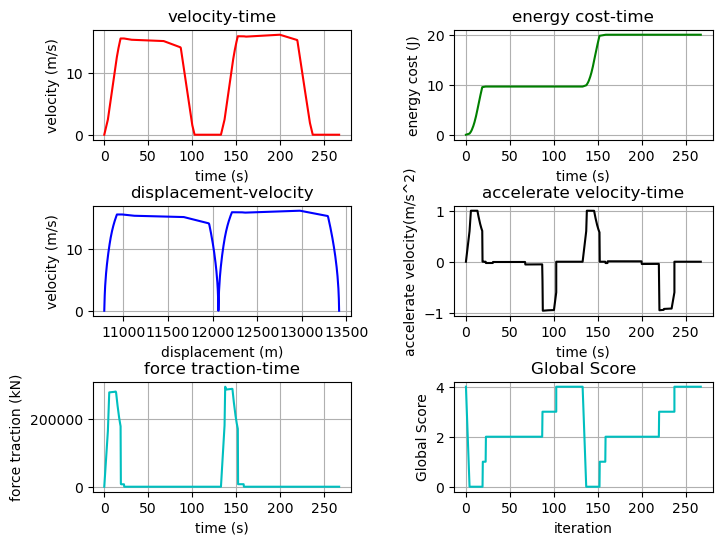

In [28]:
# xlist = gbest
xlist = [2203, 2215, 2463, 2484]

dim = 4
train5 = Train()
train5 = trainTrip(xlist, dim, station, train5, 1, 2)
w_e = 0.1 # 能耗权重
w_t = 10  # 准时性权重
fitness = w_e*train5.e[-1] + w_t*(abs(train5.arrival_time[0]-op_time[6])**3 + abs(train5.arrival_time[1]-op_time[6]-op_time[7]-30)**3)

# todo 应该重新带入最优值
time_error_L6 = (train5.arrival_time[0]-op_time[6])
time_error_L7 = (train5.arrival_time[1]-op_time[6]-op_time[7]-30)

""" 结果可视化 """

print(f'[ 最优值为：{fitness:.6f} ]')
print(f'[ 最优变量为：{xlist} ]')
print(f"[ 运行能耗：{train5.e[-1]:.3f} J]")
print(f"[ L6到站时间: {train5.arrival_time[0]:.6f} s, 误点率：{time_error_L6:.3f} s]\n"
        f"[ L7到站时间: {train5.arrival_time[1]:.6f} s, 误点率：{time_error_L7:.3f} s]")

plots = [
("velocity-time", "time (s)", "velocity (m/s)", train5.t, train5.v, 'r-'),("energy cost-time", "time (s)", "energy cost (J)", train5.t, train5.e, 'g-'),
("displacement-velocity", "displacement (m)", "velocity (m/s)", train5.s, train5.v, 'b-'),
("accelerate velocity-time", "time (s)", "accelerate velocity(m/s^2)", train5.t, train5.a, 'k-'),
("force traction-time", "time (s)", "force traction (kN)", train5.t, train5.f_t, 'c-'),
("Global Score", "iteration", "Global Score", train5.t, train5.state, 'c-')
]
# 创建一个大的图框
plt.figure(figsize=(8, 6))
# 循环创建子图
for i, (title, xlabel, ylabel, xdata, ydata, color) in enumerate(plots, start=1):
    # 创建子图，布局为3乘2
    plt.subplot(3, 2, i)
    plt.plot(xdata, ydata, color)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)
# 调整子图间距
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.6)
plt.show()

In [107]:
# minitime - 数据存储
i = 1
record_gfitness_1 = record_gfitness + [''] * (len(train5.t) - len(record_gfitness))
column_names = [f'state {i}', f't {i}', f's {i}', f'v {i}', f'a {i}', f'f_t {i}', f'f_b {i}', f'e {i}', f'gfitness {i}']
data = {column_names[0]: train5.state,
        column_names[1]: train5.t,
        column_names[2]: train5.s,
        column_names[3]: train5.v,
        column_names[4]: train5.a,
        column_names[5]: train5.f_t,
        column_names[6]: train5.f_b,
        column_names[7]: train5.e,
        column_names[8]: record_gfitness_1}

excel_filepath = 'D:\Python\Jupyter_Code\CASCO\paper2\\results\\train1_operation_5.xlsx'
excelTools.dfStorage(data, excel_filepath, {i})

successful storage in D:\Python\Jupyter_Code\CASCO\paper2\results\train1_operation_5.xlsx


In [59]:
excelTools.fontSet(excel_filepath)